# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt; plt.rcdefaults()

In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import pickle


# TODO: fill this in based on where you saved the training and testing data

training_file = "train.p"

testing_file = "test.p"

with open(training_file, mode='rb') as f:

    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    
    test = pickle.load(f)

signs = pd.read_csv("signnames.csv")
    
X_train, y_train = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']
Coord_train = train['coords']
Coord_test = test['coords']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: number of testing examples
#this is for later
#n_my_test = my_test_X.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))
# TODO: how many classes are in the dataset
n_classes_lb = len(set(test['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape, 32*32)
print("Number of training classes =", n_classes )
print("Number of test classes =", n_classes_lb )

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32) 1024
Number of training classes = 43
Number of test classes = 43


In [4]:
#finding labels count for each class. Maximum is 30*75, thats why calculating the number of images for each class to be generated.

label_freq_train = pd.Series(y_train)
label_freq_train = label_freq_train.value_counts().sort_values()
label_freq_train.index = signs['SignName'][label_freq_train.index]

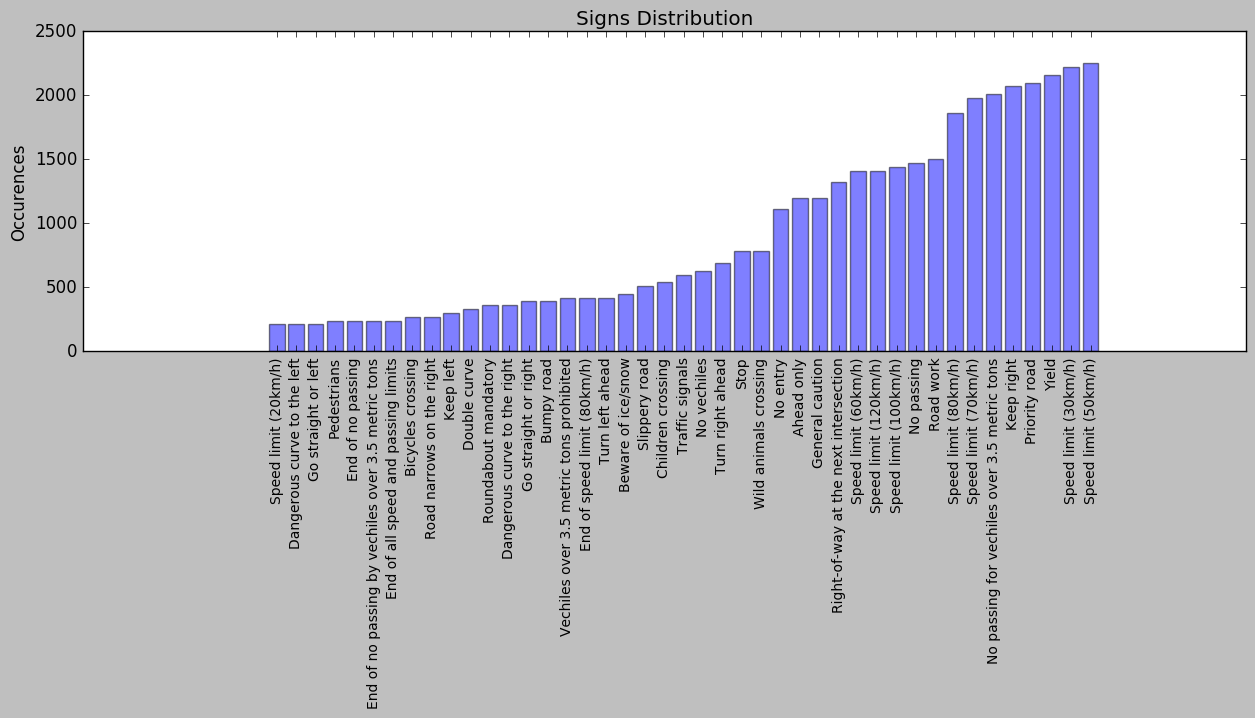

In [5]:
objects = label_freq_train.index.values
y_pos = np.arange(len(objects))
performance = label_freq_train.values
 
plt.figure(figsize=(15,4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical',size='small')
plt.ylabel('Occurences')
plt.title('Signs Distribution')
 
plt.show()

In [6]:
label_freq_test = pd.Series(y_test)
label_freq_test = label_freq_test.value_counts().sort_values()
label_freq_test.index = signs['SignName'][label_freq_test.index]

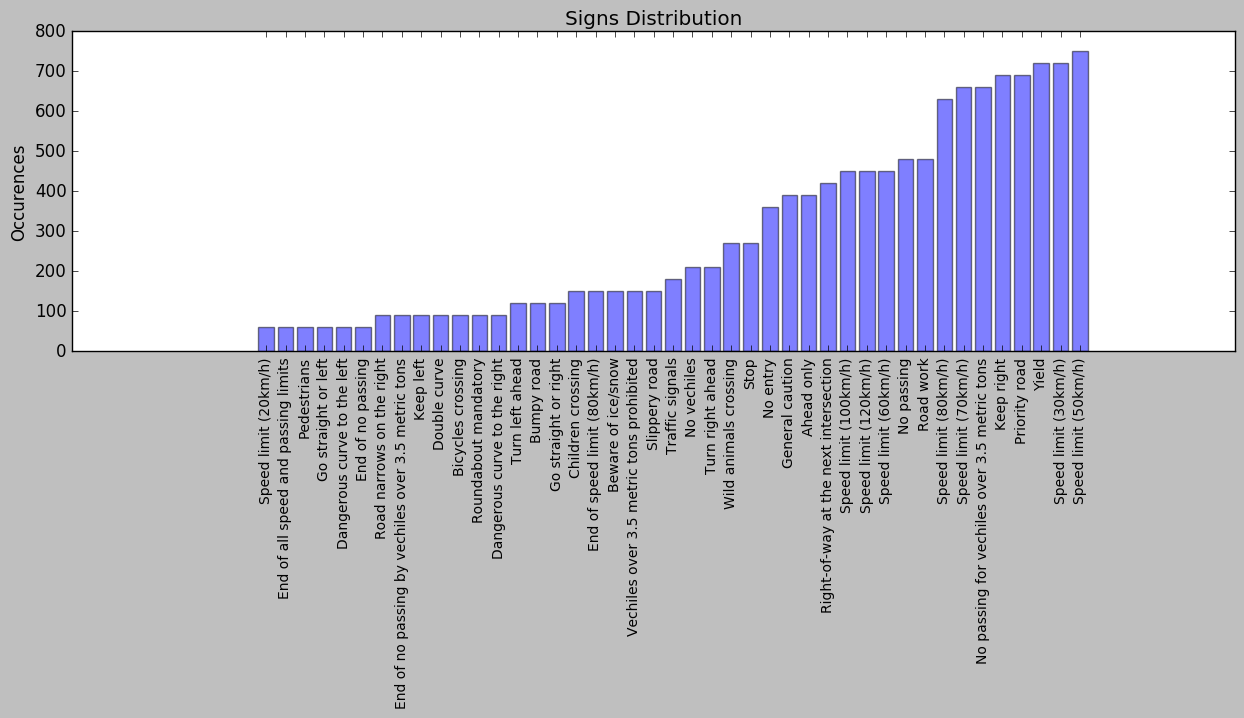

In [7]:
objects = label_freq_test.index.values
y_pos = np.arange(len(objects))
performance = label_freq_test.values
 
plt.figure(figsize=(15,4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical',size='small')
plt.ylabel('Occurences')
plt.title('Signs Distribution')
 
plt.show()

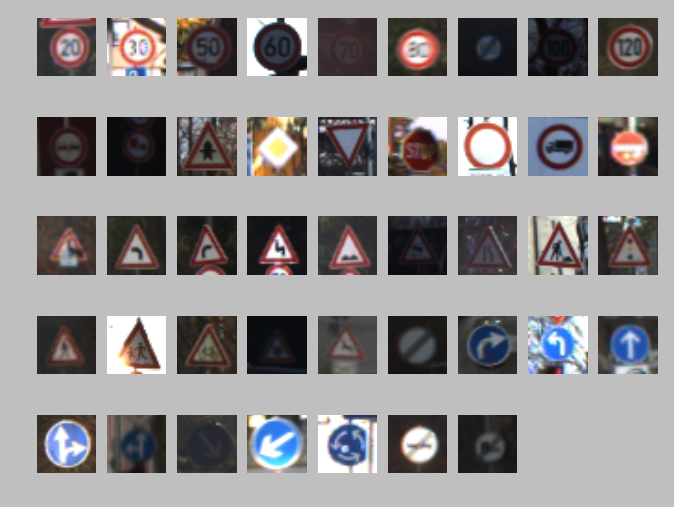

In [8]:
row = 5
col = 9

for i in range(43):
    for j in range(len(y_test)):
        if(y_test[j]==i):
            plt.subplot(row, col, i+1)
            plt.axis('off')
            plt.imshow(X_test[j])
            continue
    
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
#Here I am resizing the image. Kept 32 pixels but test with different scenarios. 
#Also, focusing on the sign rectangle
import cv2
new_size = 32

for i in range (len(X_train)):
    img = X_train[i]
    img = img[Coord_train[i][1]:Coord_train[i][3],Coord_train[i][0]:Coord_train[i][2]]
    img= cv2.resize(img,(new_size,new_size))
    X_train[i] = img

for i in range (len(X_test)):
    img = X_test[i]
    img = img[Coord_test[i][1]:Coord_test[i][3],Coord_test[i][0]:Coord_test[i][2]]
    img= cv2.resize(img,(new_size,new_size))
    X_test[i] = img

In [10]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [11]:
#finding labels count for each class. Maximum is 30*75, thats why calculating the number of images for each class to be generated.

label_freq = pd.Series(y_train)
a = label_freq.value_counts().sort_values()
a = abs(a/30-75)

In [12]:
# For each class find the count of images to be genrated, a random image of that is selected, and for each selection 30 new
#images are being genrated.

import random
new_train = []
new_labels= []
for i in range(43):
    to_be_selected = int(a[i])
    labels_np = np.where(y_train==i)[0]
    for j in range(to_be_selected):
        for k in range(30):
            new_train.append(transform_image(X_train[random.choice(labels_np)],20,10,5))
            new_labels.append(i)


In [13]:
#appending the newly genrated images to old data
final_train = []
final_labels = []
for i in range(len(X_train)):
    final_train.append(X_train[i])
    final_labels.append(y_train[i])
    
for i in range(len(new_train)):
    final_train.append(new_train[i])
    final_labels.append(new_labels[i])
    
X_train=np.array(final_train)
y_train = np.array(final_labels)

In [14]:
len(X_train)

96749

In [15]:
#converting to gray scale images
def bgr_to_gray(array):
        gray = []
        for i in range(len(array)):
            image = array[i]
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray.append(gray_image)
            
        return np.array(gray)

X_train = bgr_to_gray(X_train)
X_test = bgr_to_gray(X_test)


In [16]:
#Flattening the arrays
def flatten_array(array):
        ar = []
        for i in range(len(array)):
            image = array[i]
            f = np.array(image, dtype=np.float32).flatten()
            ar.append(f)

        return np.array(ar) 
    
X_train = flatten_array(X_train)
X_test = flatten_array(X_test)

In [17]:
# doing normalization
def normalize_greyscale(image_data):
    
    a= 0.1
    b= 0.9
    min = 0
    max =255
    
    #value = 0.1 + ((image_data- min)*(b-a))/(max-min)
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

X_train = normalize_greyscale(X_train)
X_test = normalize_greyscale(X_test)

In [18]:
y_train = (np.arange(43) == y_train[:,None]).astype(np.float32)
y_test = (np.arange(43) == y_test[:,None]).astype(np.float32)


In [19]:
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.15,random_state=832289)

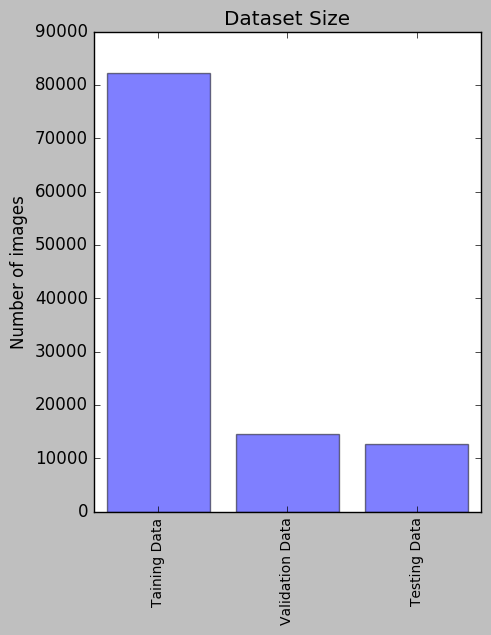

In [21]:
objects = ("Taining Data","Validation Data","Testing Data")
y_pos = np.arange(len(objects))
performance = [len(X_train),len(X_valid),len(X_test)]
 
plt.figure(figsize=(5,6))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical',size='small')
plt.title('Dataset Size')
plt.ylabel('Number of images')
 
plt.show()

In [22]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** 
1. Number of training examples = 39209. Number of testing examples = 12630
2. Drew the bar graph for training and testing datasets. In both cases, "Speed Limit 20 Km/h" is the traffic sign with minimum frequency whereas "Speed Limit 50 Km/h" has the maximum frequency. Also, printed one example for each traffic sign, to see the signs. 
3. Then, I am resizing the image. Kept 32 pixels but tested with different scenarios. Focusing on the sign rectangle using bounding box coordinates.
4. Used transform image function, to generate more data.
5. Found labels count for each class. Maximum is 30*75, then calculating the number of images for each class to be generated, so that each class has almost equal number of images. 
6. Converted the images to gray scale, then falttened the image pixels, and normalized the images.   
7. Why grayscale? Many computer vision algorithms definitely work better on grayscale images. The reason is basically that the information they require is the "shape" of image contents, which is best represented in the brightness component – roughly what grayscale images show.In our specific problem of traffic sign classification, color is not strictly necessary, as signs can be differentiated by shape alone. In that case converting images to grayscale may help by making shape differences more explicit, while removing irrelevant differences (such as color shade differences among signs in the same class).
8. Why Flattened? When we use convnets, we are in a way counting the number filter occurence (left edges, circles, etc), and making estimation based on those features, instead of directly comparing with a template. So flattening in this case preserves some additional information about the images.
9. Why normalized? To imporove the contrast in the images. 

In [23]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
1. Newly generated data became the part of original training data. Total number of images in training data becomes 96749.
2. Then, made 15% of that total data part of validation data. Test data remained unchanged. Generated additional data, because some classes had more data then the others and it would have resulted for the model to be biased towards some classes.  
3. Number of images in training dataset  = 82236
4. Number of images in validation dataset = 14153
5. Number of images in testing dataset = 12630

In [24]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [25]:
batch_size = 50
training_epochs = 200

n_input = 1024  # Image data input (Shape: 32*32)
n_classes = 43  # total classes (43 signs)

In [26]:
sess = tf.InteractiveSession()

In [27]:
#creating a 2Dtensor placeholder
#none means that this dimension can be of any length
x = tf.placeholder(tf.float32,shape=[None, 1024])

#tensors full of zeros for wx+b calculations
W = tf.Variable(tf.zeros([1024,43]))
b = tf.Variable(tf.zeros([43]))

#to implement cross entropy,a new placeholder to input correct answers

y_ = tf.placeholder(tf.float32,[None,43])

In [28]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

In [29]:
def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

In [30]:
def conv2d(x,W):
    return tf.nn.conv2d(x , W, strides=[1,1,1,1],padding='SAME')


In [31]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],
                        strides=[1,2,2,1],padding='SAME')

In [32]:
#first convolution layer: 5*5 patch, 1 input channel, 32 output channels

W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

#image width=32, height=32, color channel = 1
x_image = tf.reshape(x,[-1,32,32,1])

#convolve c_image with weight tensor, add bias, apply relu and max ppol

h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1)+ b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [33]:
#seconnd layer
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [34]:
#densely connected layer

W_fc1 = weight_variable([8*8*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)

In [35]:
#drop out

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

In [36]:
#readout layer

W_fc2 = weight_variable([1024,43])
b_fc2 = bias_variable([43])

y_conv = tf.matmul(h_fc1_drop,W_fc2)+b_fc2

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
1. The final model is a CNN, with two hidden layers of convolutions of patch 5*5 followed by k=2 max-pooling. After that 0.5 dropout for training,then a fully connected layer, and a read out layer.
2. For weights used the trucated_normal() with stddev=0.1
3. bias = 0.1
4. For convolutions, stride = 1 and padding = 'SAME'
5. For maxpool,k=2,strides= 2 and padding='SAME' 
6. Input: [?,1024] as 32x32=1024
7. convoltuion 1 = [5x5x1x32]
8. Relu : to make the computations simpler
9. maxpool 2x2: reducing overfitting and dimensionality to get accurate results
10. convoltuion 2 = [5x5x32x64]
11. Relu : to make the computations simpler
12. maxpool 2x2: reducing overfitting and dimensionality to get accurate results
13. Fully Connected = [4096,1024]
14. dropout = 0.5 for training to avoid overfitting
15. Output: [1024,43]


In [37]:
soft_max = tf.nn.softmax(y_conv)

In [38]:

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_conv,y_)
loss = tf.reduce_mean(cross_entropy)

In [39]:
train_step = tf.train.AdamOptimizer(8.8e-4).minimize(loss)

In [40]:
prediction=tf.argmax(y_conv,1)
correct_prediction = tf.equal(prediction,tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [41]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [42]:
sess.run(tf.initialize_all_variables())

In [43]:
stop = 0
for epoch in range(training_epochs):
    if(stop==0):
        count = 0
        print("*"*80)
        print("epoch : %d"%(epoch))
        total_batch = int(len(X_train)/batch_size)
        for i in range(total_batch):
            offset = (i*batch_size) 
        
            train_step.run(feed_dict={x: X_train[offset:offset+batch_size], y_: y_train[offset:offset+batch_size],keep_prob:0.5})
            #if(i%100==0):
            #    train_accuracy = accuracy.eval(feed_dict={x: X_train[offset:offset+batch_size], y_: y_train[offset:offset+batch_size],keep_prob:1})
            #    print("batch %d,training accuracy %g"%(i,train_accuracy))
    
    
        total_valid_batch = int(len(y_valid)/batch_size)
        for i in range(total_valid_batch):
            offset = (i*batch_size) 
            if(i%100==0):    
                valid_accuracy = accuracy.eval(feed_dict={x: X_valid[offset:offset+batch_size], y_: y_valid[offset:offset+batch_size],keep_prob:1.0})
                print("batch %d,Validation accuracy %g"%(i,valid_accuracy))
            if(valid_accuracy>= 0.98):
                count = count + 1
            if(i==total_valid_batch-1 and count==total_valid_batch-1):
                stop = 1
    elif(stop==1):
        print("validation accuracy for all the batches was greater then 98 percent, thats why no further training")
        break
    


********************************************************************************
epoch : 0
batch 0,Validation accuracy 0.74
batch 100,Validation accuracy 0.84
batch 200,Validation accuracy 0.7
********************************************************************************
epoch : 1
batch 0,Validation accuracy 0.82
batch 100,Validation accuracy 0.94
batch 200,Validation accuracy 0.78
********************************************************************************
epoch : 2
batch 0,Validation accuracy 0.94
batch 100,Validation accuracy 0.96
batch 200,Validation accuracy 0.86
********************************************************************************
epoch : 3
batch 0,Validation accuracy 0.96
batch 100,Validation accuracy 0.98
batch 200,Validation accuracy 0.94
********************************************************************************
epoch : 4
batch 0,Validation accuracy 0.98
batch 100,Validation accuracy 0.98
batch 200,Validation accuracy 0.94
*******************************

In [44]:
test_accuracy = accuracy.eval(feed_dict={x:X_test,y_:y_test,keep_prob:1.0})
print("test accuracy %g"%(test_accuracy))

test accuracy 0.935471


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
1. Optimizer: AdamOptimizer. The tf.train.AdamOptimizer uses Kingma and Ba's Adam algorithm to control the learning rate. Adam offers several advantages over the simple tf.train.GradientDescentOptimizer. Foremost is that it uses moving averages of the parameters (momentum). Simply put, this enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning. The main down side of the algorithm is that Adam requires more computation to be performed for each parameter in each training step (to maintain the moving averages and variance, and calculate the scaled gradient); and more state to be retained for each parameter (approximately tripling the size of the model to store the average and variance for each parameter). A simple tf.train.GradientDescentOptimizer could equally be used, but would require more hyperparameter tuning before it would converge as quickly.
2) Batch: 50
3) epochs: 200 but stop training earlier if validation accuracy for all the batches in validation dataset is greater then or equal to 98%

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
1. As deep learning is the science, I had to try many diferent models to come up with this final model.
2. Wrote the two layered inception module, but that solution felt too much for this problem and was very slow on my pc. The results were not so good so had to look for other options. What I learnt is that I should always try to write a simpler model first and then step by step, try to improve the accuracy.
3. I did not write a simple linear model though, as after going through the lectures, I was sure that convolution neural network would give better results. It is because of weight sharing for translation invariance and maxpooling. 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

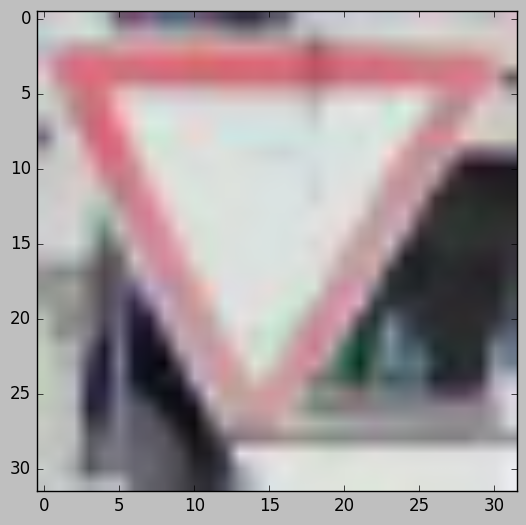

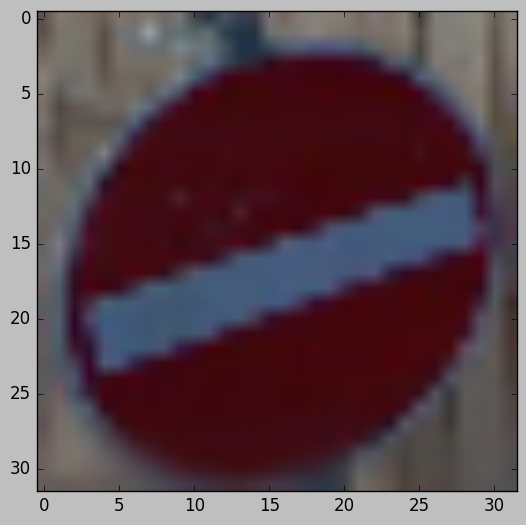

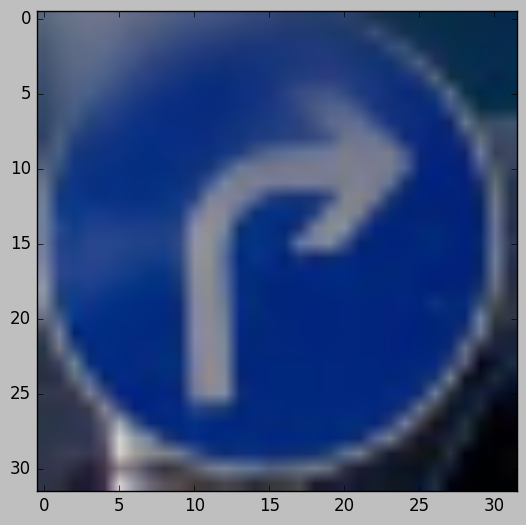

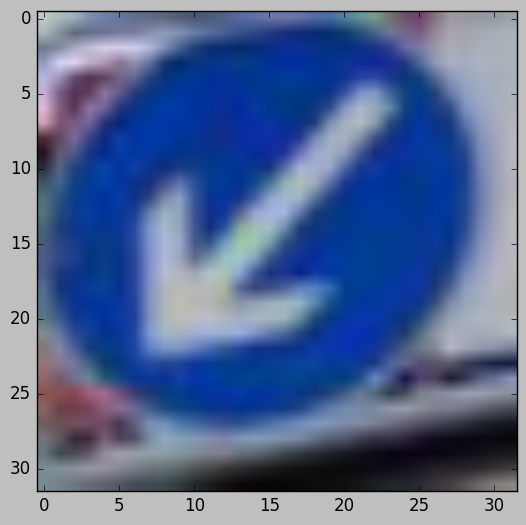

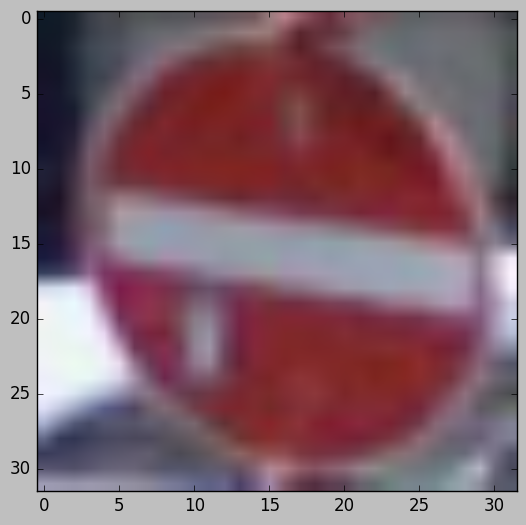

In [45]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


images = []
image_labels = []
img=mpimg.imread('sign1.jpg')
img= cv2.resize(img,(new_size,new_size))
images.append(img)
image_labels.append(13)

img=mpimg.imread('sign2.jpg')
img= cv2.resize(img,(new_size,new_size))
images.append(img)
image_labels.append(17)

img=mpimg.imread('sign3.jpg')
img= cv2.resize(img,(new_size,new_size))
images.append(img)
image_labels.append(33)

img=mpimg.imread('sign5.jpg')
img= cv2.resize(img,(new_size,new_size))
images.append(img)
image_labels.append(39)

img=mpimg.imread('sign6.jpg')
img= cv2.resize(img,(new_size,new_size))
images.append(img)
image_labels.append(17)

images = np.array(images)
image_labels = np.array(image_labels)

images.shape

for i in range(5):
    plt.figure(i+1)
    plt.imshow(images[i])
    
plt.show()

In [46]:
images = bgr_to_gray(images)
images = flatten_array(images)
images = normalize_greyscale(images)


In [47]:
image_labels = (np.arange(43) == image_labels[:,None]).astype(np.float32)

In [48]:
image_labels = np.array(image_labels).astype(np.float32)

In [49]:
image_labels.shape

(5, 43)

In [50]:
signs

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** Captured these images using google street view. First and fourth images are normal and model should not have any problem identifying these. Second and fifth images are of no entry and the horizontal white line has a different angle(not exactly horizontal). Fifth sign image also has a sticker  on it. Third sign image is blurred in the top half. 

In [51]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [52]:
new_test_accuracy = accuracy.eval(feed_dict={x:images,y_:image_labels,keep_prob:1.0})
print("test accuracy %g"%(new_test_accuracy))

test accuracy 1


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** On the captured images, model performed even better then the testing dataset. On captured images, accuracy is 1 whereas on testing data set, accuracy is 0.935471. There can be many reasons for that. The most important is that the set of 5 images do not represent the wide array of different signs and this set is proven to be too easy for the model and does not cover all the scnearios. Another reason is the size of set, which is 5. Let's assume that we add and test a new sign image which for its complexity could not be predicted accurately and then we could say that the accuracy on captured images was closed to test set accuracy.  

In [53]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.


In [54]:
cross_entropy.eval(feed_dict={x:images,y_:image_labels,keep_prob:1.0})

array([ 0.,  0.,  0.,  0.,  0.], dtype=float32)

In [55]:
loss.eval(feed_dict={x:images,y_:image_labels,keep_prob:1.0})

0.0

In [56]:
correct_prediction.eval(feed_dict={x:images,y_:image_labels,keep_prob:1.0})


array([ True,  True,  True,  True,  True], dtype=bool)

In [57]:
predictions = prediction.eval(feed_dict={x: images,keep_prob:1.0})

In [58]:
sess.run(tf.nn.top_k(prediction.eval(feed_dict={x: images,keep_prob:1.0}) , k=5))

TopKV2(values=array([39, 33, 17, 17, 13]), indices=array([3, 2, 1, 4, 0], dtype=int32))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** I calculated the predictions. All signs were predicted correctly. I checked the certainity of my results and found out that model is 100% sure about all the results. 

In [59]:
top_k_preds = sess.run(tf.nn.top_k(tf.nn.softmax(y_conv) , k=5), feed_dict={x: images, y_: image_labels, keep_prob: 1.0})

In [63]:
values = top_k_preds.values
indices = top_k_preds.indices

for i in range(0,len(image_labels)):
    flag =""
    predict = predictions[i]    
    correct = np.argmax(image_labels[i])
    if (predict == correct):
        flag = "Correct!"
        certainty = np.round((values[i][0]*100),1)
        print ("My test prediction for image %d is: %d. The true value is: %d %s With a certainty of: %s %s"%(i,predict,correct,flag,certainty,'%'))

    else:
        flag = "  "
        certainty = ""
        for j in range(0,len(indices[0])):
            if (indices[j][0] == correct):
                #If correct index is in top 5 calculate certainty
                certainty = np.round((values[i][j]*100),1)
                print ("My test prediction for image %d is: %d. The true value is: %d %s With a certainty of: %s %s"%(i,predict,correct,flag,certainty,'%'))
        print ("My test prediction for image %d is: %d. The true value is: %d %s The correct index %d not in top 5"%(i,predict,correct,flag,correct))

My test prediction for image 0 is: 13. The true value is: 13 Correct! With a certainty of: 100.0 %
My test prediction for image 1 is: 17. The true value is: 17 Correct! With a certainty of: 100.0 %
My test prediction for image 2 is: 33. The true value is: 33 Correct! With a certainty of: 100.0 %
My test prediction for image 3 is: 39. The true value is: 39 Correct! With a certainty of: 100.0 %
My test prediction for image 4 is: 17. The true value is: 17 Correct! With a certainty of: 100.0 %


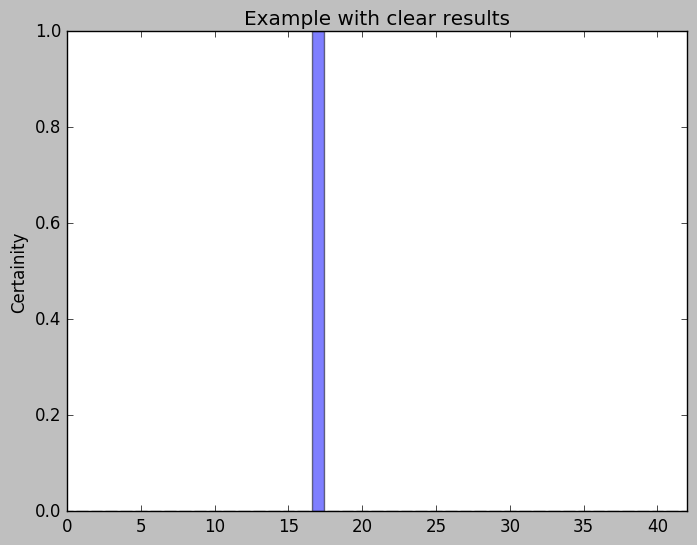

In [64]:
softmaxprob = soft_max.eval(feed_dict={x:images , y_: image_labels, keep_prob: 1.0})[1]

import matplotlib.pyplot as plt; plt.rcdefaults()

plt.bar(list(range(43)), list(softmaxprob), align='center', alpha=0.5)
plt.xlim(0,42)
plt.ylabel('Certainity')
plt.title('Example with clear results')
 
plt.show()